In [12]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

%matplotlib inline

In [13]:
ranks = np.array(['A', '2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K'])
values = {'A':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, 'T':10, 'J':10, 'Q':10, 'K':10}

In [14]:
def get_card():
    return np.random.choice(ranks)

In [15]:
def emulate_dealer(dealer):
    while dealer < 17:
        dealer += values[get_card()]
    return dealer

In [16]:
def get_result(player, dealer):
    if player == dealer:
        return 0
    if player < dealer or player > 21:
        return -1
    return 1

In [17]:
ϵ = 0.05

In [18]:
class StateAction:
    def __init__(self, player_sum, dealer_card, useable_ace):
        self.value = np.array([0,0])
        self.returns = [[],[]]
        self.policy = [0.5, 0.5]
        self.action = ['hit', 'stick']
        self.player_sum = player_sum
        self.dealer_card = dealer_card
        self.useable_ace = useable_ace
        
    def __repr__(self):
        return "player sum: {ps}, dealer card: {dc}, useable ace: {us}, value: {v}, actions: {a}, policy: {p}".format(
            ps=self.player_sum, dc=self.dealer_card, us=self.useable_ace, a=self.action, v=self.value, p=self.policy)
    
    def get_action(self):
        return np.random.choice(self.action, p=self.policy)

In [19]:
db = 1
pb = 12
useable_ace = False
max_iter = 5000

In [20]:
states = np.array([[[StateAction(ps, dc, us) for ps in range(12, 22)] for dc in range(1, 11)] for us in [True, False]])

In [21]:
total_score = [0]

for i in range(max_iter):
    useable_ace = ~useable_ace
    used_ace = False
    action = 'hit'
    player = 0
    dealer = values[get_card()]

    while player < 12:
        card = get_card()
        if card == 'A' and useable_ace and ~used_ace:
            player += 11
            used_ace = True
        else:
            player += values[card]

    if player <= 21:
        curr_state = states[0 if useable_ace else 1, dealer - db, player - pb]
        action = curr_state.get_action()
        appearing_states = [(curr_state, action)]
    
    while player <= 21 and action == 'hit':
        card = get_card()
        if card == 'A' and useable_ace and ~used_ace:
            player += 11
            used_ace = True
        else:
            player += values[card]
        if player > 21:
            break
        curr_state = states[0 if useable_ace else 1, dealer - db, player - pb]
        action = curr_state.get_action()
        appearing_states.append((curr_state, action))
        
    result = get_result(player, emulate_dealer(dealer))
    total_score.append(total_score[-1] + result)
    
    for state, action in appearing_states:
        state.returns[0 if action == 'hit' else 1].append(result)
        tmp = state.returns[0 if action == 'hit' else 1]
        state.value[0 if action == 'hit' else 1] = sum(tmp) / len(tmp)
        
    for state, _ in appearing_states:
        if state.value[0] > state.value[1]:
            ind1, ind2 = 0, 1
        else:
            ind1, ind2 = 1, 0
        state.policy[ind1] = 1 - ϵ
        state.policy[ind2] = ϵ
        

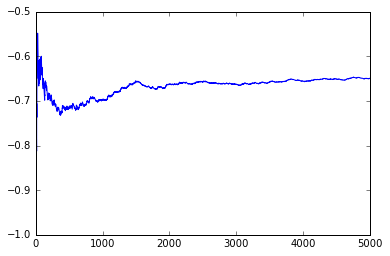

In [22]:
total_score = np.array(total_score[1:])
it = np.arange(1, max_iter+1)

plt.plot(it, total_score/it)